This shows how to find descriptive parameters (short formulas) to predict materials properties using compressed sensing tools. As an example, we address the prediction of the workfunction value of 2D material called MXenes.

The main models used here can be found in the original paper: 

R. Ouyang, S. Curtarolo, E. Ahmetcik, M. Scheffler, L. M. Ghiringhelli: <span style="font-style: italic;">SISSO: a compressed-sensing method for identifying the best low-dimensional descriptor in an immensity of offered candidates</span>, Phys. Rev. Materials  2, 083802 (2018) <a href="https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.2.083802" target="_blank">[PDF]</a> .

# Introduction to the compressed sensing methods

The feature space is generated by creating a list of analytical expressions (the derived features), obtained by combining <i> primary features </i> and arithmetic operations. In this example, the primary features are properties of isolated atoms, such as electron affinity or the radial extension of valence orbitals. We put all $m$ derived features into a descriptor matrix $\mathbf{D} \in \mathbb{R}^{82 \times m}$ where each column stands for a derived feature and each row for a compound. An $\ell_0$-regularization 

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_0\}$

determines those few feature columns which approximate a property vector $\mathbf{P} \in \mathbb{R}^{82}$ (i.e RS vs. ZB energy differences) best. The subscript 0 stands for the $\ell_0$-quasinorm, that counts the number of non-zero elements of $\mathbf{c}$ and $\lambda > 0$ is called the regularization parameter. Performing the $\ell_0$-regularization becomes fast computational infeasable and often approximations (i.e. LASSO, orthogonal matching pursuit) are needed since in practice the $\ell_0$-regularization needs to be solved combinatorial: All singletons, pairs, triplets, ... $n$-tuples (up to the selected maximum dimension of the descriptor) are listed and for each set a least-square regression is performed. The $n$-tuple that gives the lowest mean square error for the least-square regression fit is selected as the resulting $n$-dimensional descriptor.

### The LASSO method
A convex optimization problem can be introduced by the Least Absolute Shrinkage and Selection Operator (LASSO):

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_1\}$.

Under certain conditions on the matrix $\mathbf{D}$, it can find the exact solution of, or a good approximation to, the $\ell_0$-regularization problem.


### The SISSO method
SISSO works iteratively. In the first iteration, a number $k$ of features is collected that have the largest correlation (scalar product) with $\mathbf{P}$. The feature with the largest correlation is simply the 1D descriptor. Next, a residual is constructed as the error made in the first iteration. A new set of $k$ features is now selected as those having the largest correlation with the residual. The 2D descriptor is the pair of features that yield the smallest fitting error upon least-square regression, among all possible pairs contained in the union of the sets selected in this and the first iteration. In each next iteration a new residual is constructed as the error made in the previous iteration, then a new set of $k$ features is extracted as those that have largest correlation with each new residual. The $n$D descriptor is the $n$-tuple of features that yield the smallest fitting error upon least square regression, among all possible $n$-tuples contained in the union of the sets obtained in each new iteration and all the previous iterations. If $k=1$ the method collapses to the so-called orthogonal matching pursuit.
<img  src="assets/compressed_sensing/SISSO.png" width="800"> 

# Import required modules

In [3]:
import os
import pandas as pd
import numpy as np
from itertools import combinations, product
from time import time
import matplotlib.pyplot as plt 
from sklearn.linear_model import Lasso
import scipy.stats as ss
import warnings
from collections import Counter
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from IPython.display import HTML
from jupyter_jsmol import JsmolView
import pathlib


import nglview
from ase.units import J

from compressed_sensing.sisso import SissoRegressor
from compressed_sensing.combine_features import combine_features
from compressed_sensing.scatter_plot import  show_scatter_plot
from compressed_sensing.visualizer import Visualizer
# from sissopp import Inputs, FeatureSpace, SISSORegressor, FeatureNode, Unit
# from sissopp.py_interface import read_csv
# from sissopp.py_interface.import_dataframe import get_unit

from atomicfeaturespackage.atomicproperties import atomic_properties_lda2015
from nomad import client, config
from nomad.client import ArchiveQuery
from nomad.metainfo import units

# set display options for the notebook 
# %matplotlib inline
warnings.filterwarnings('ignore')

Loading BokehJS ...

# Get the data
We obtained the data from Computational 2D Materials Database (C2DB) https://cmr.fysik.dtu.dk/c2db/c2db.html 




In [4]:
df_2 = pd.read_csv("C2DB_Sample_Data_copy_2(dropped).csv") #need to check its location later
df_2.dropna(inplace=True)
df_2.columns


# df_2.columns[5]

Index(['Formula', 'M', 'X', 'T', 'Work function (eV)', 'HoF (eV/atom)',
       'E-CH (eV/atom)', 'Length(x) [A]', 'r-(M) [pm]', 'r-(X) [pm]',
       'r-(T) [pm]', 'IP(M) [eV]', 'IP(X) [eV]', 'IP(T) [eV]', 'EN(M)',
       'EN(X)', 'EN(T)', 'EA(M) [eV]', 'EA(X) [eV]', 'EA(T) [eV]'],
      dtype='object')

In [5]:
# ordered_selected_features = ["EN(T)","Length(x) [A]", "IP(X) [eV]","r-(M) [pm]","r-(T) [pm]"]
ordered_selected_features = ["EN(T)","Length(x) [A]", "IP(X) [eV]","r-(M) [pm]","r-(T) [pm]"]
df_2[ordered_selected_features] #top seven selected from Pranav's research. check the order of importance later 
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Formula             275 non-null    object 
 1   M                   275 non-null    object 
 2   X                   275 non-null    object 
 3   T                   275 non-null    object 
 4   Work function (eV)  275 non-null    float64
 5   HoF (eV/atom)       275 non-null    float64
 6   E-CH (eV/atom)      275 non-null    float64
 7   Length(x) [A]       275 non-null    float64
 8   r-(M) [pm]          275 non-null    float64
 9   r-(X) [pm]          275 non-null    float64
 10  r-(T) [pm]          275 non-null    float64
 11  IP(M) [eV]          275 non-null    float64
 12  IP(X) [eV]          275 non-null    float64
 13  IP(T) [eV]          275 non-null    float64
 14  EN(M)               275 non-null    float64
 15  EN(X)               275 non-null    float64
 16  EN(T)   

In [5]:
def get_data_new(selected_feature_list, allowed_operations):
    
    # extract work function and selected features from df 
    P = df_2['Work function (eV)'].values
    df_features = df_2.iloc[:, 5:][selected_feature_list]
    print("df_features.columns", df_features.columns)
    
    # derive new features using allowed_operations
    df_combined = combine_features(df=df_features, allowed_operations=allowed_operations)
    return P, df_combined

#don't fully get these parts.

In [6]:
# EDIT THIS !!!!!

get_data = get_data_new

In [7]:
selected_feature_list = ['EN(T)', 'Length(x) [A]']

# allowed_operations = ['+', '-', '|-|', '/' '^2', '^3',  'exp']
allowed_operations = ['+']

P, df_D = get_data(selected_feature_list, allowed_operations)

# print derived features
df_D

df_features.columns Index(['EN(T)', 'Length(x) [A]'], dtype='object')
Selected operations:
 ['+']
DF_A3 Index(['EN(T)', 'Length(x) [A]'], dtype='object')
Number of total features generated: 3


,EN(T),Length(x) [A],(EN(T)+Length(x) [A])
0,2.82,330.399994,333.220001
1,2.82,335.000000,337.820007
2,2.82,290.600006,293.420013
3,2.82,285.000000,287.820007
4,2.82,298.899994,301.720001
...,...,...,...
270,2.82,330.000000,332.820007
271,2.82,291.500000,294.320007
272,2.82,326.100006,328.920013
273,2.82,322.000000,324.820007



# Determining low-dimensional descriptors with the $\ell_0$ method

<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li> Perform an l0-regularization to identify the best low dimensional descriptors using the primary features.</li>
<li> Show that non-linear functions of the primary features improve the models significantly. </li>
<li> See that the l0-regularization can rapidly become computational infeasible.</li>
</div>

Our target is to find the best low dimensional descriptor for a linear model $\mathbf{P} = \mathbf{D^\ast}\mathbf{c^\ast}$, where $\mathbf{c^\ast}$ is the vector of nonzero elements of the solution vector $\mathbf{c}$ and $\mathbf{D^\ast}$ is the matrix of the columns of $\mathbf{D}$ corresponding to the nonzero elements of $\mathbf{c}$. The $\ell_0$ regularization

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_0\}$

provides exactly what we want. It is defined in the following and solved combinatorial:

In [8]:
def L0(P, D, dimension):
    n_rows, n_columns = D.shape
    D = np.column_stack((D, np.ones(n_rows)))
    SE_min = np.inner(P ,P)
    coef_min, permu_min = None, None
    for permu in combinations(range(n_columns), dimension):
        D_ls = D[:, permu + (-1,)]
        coef, SE, __1, __2 = np.linalg.lstsq(D_ls, P, rcond=-1) #error later 
        try:
            if SE[0] < SE_min: 
                SE_min = SE[0]
                coef_min, permu_min = coef, permu
        except:
            pass
    RMSE = np.sqrt(SE_min/n_rows)
    return RMSE, coef_min, permu_min

Perform the $\ell_0$-regularization for different dimensions (numbers of non-zero coefficients in the model) and see the root mean square errors (RMSE) and the selected features.

In [9]:
df_D

,EN(T),Length(x) [A],(EN(T)+Length(x) [A])
0,2.82,330.399994,333.220001
1,2.82,335.000000,337.820007
2,2.82,290.600006,293.420013
3,2.82,285.000000,287.820007
4,2.82,298.899994,301.720001
...,...,...,...
270,2.82,330.000000,332.820007
271,2.82,291.500000,294.320007
272,2.82,326.100006,328.920013
273,2.82,322.000000,324.820007


In [10]:
selected_feature_list = ["EN(T)","Length(x) [A]", "IP(X) [eV]","r-(M) [pm]","r-(T) [pm]"]
allowed_operations = ['+']

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
D = df_D.values
print (df_D)

print("     RMSE   Best desriptor")
for dim in range(1,4):
    RMSE, coefficients, selected_indices = L0(P,D,dim)
    print('%2sD: %.5f' % (dim, RMSE), [features_list[i] for i in selected_indices]) 

#without [features_list[i] for i in selected_indices], no error and operates till 10D -- that is because 3 is the maximum possible combination?  
#create a loop that goes till 3D. i think the rest of the error will be solved? Correct! 




df_features.columns Index(['EN(T)', 'Length(x) [A]', 'IP(X) [eV]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
Selected operations:
 ['+']
DF_A3 Index(['EN(T)', 'Length(x) [A]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
Number of total features generated: 11
     IP(X) [eV]  EN(T)  Length(x) [A]  r-(M) [pm]  r-(T) [pm]  \
0       11.2603   2.82     330.399994   82.900002   41.400002   
1       11.2603   2.82     335.000000   53.900002   41.400002   
2       11.2603   2.82     290.600006   74.599998   41.400002   
3       14.5341   2.82     285.000000   70.199997   41.400002   
4       14.5341   2.82     298.899994   48.900002   41.400002   
..          ...    ...            ...         ...         ...   
270     11.2603   2.82     330.000000   53.900002   41.400002   
271     11.2603   2.82     291.500000   74.599998   41.400002   
272     14.5341   2.82     326.100006   82.900002   41.400002   
273     14.5341   2.82     322.000000   53.900002   41.400002   
274     14.5341   2.82

The result of performing the $\ell_0$-regularization shows that the accuracy converges fast, e.g. we could leave out some components in the linear model without decreasing the accuracy. The second observation is that a linear model of the atomic features is not enough to describe the RS-ZB energy differences. A way out could be using non-linear machine learning models, e.g. kernel ridge regression or a neural network, instead of linear regression. Another way is to put the non-linearity into the descriptors by building algebraic combinations of the atomic features and mapping the few best of these more complex features onto the target again with a linear model. 

Run the following script to build larger feature spaces of more complex features and select the best 1D, 2D and 3D descriptor for a linear model using $\ell_0$-regularization. Plot the results afterwards. How does the accuracy of the models change? How does the feature space size and the dimension of the descriptors depend on the needed time to solve the $\ell_0$-problem?

In [11]:
selected_feature_list = ordered_selected_features[:7]
op_lists = [[], ['+','|-|'],['+','|-|'],['+','|-|','^2'],['+','|-|','^2', '^3']]
#['+','-','|-|','^2', '^3','/']

X  = [] #what was this again? 
Errors, Time = np.empty([3,len(op_lists)]), np.empty([3,len(op_lists)])

for n_op, allowed_operations in enumerate(op_lists):
    P, df_D = get_data(selected_feature_list, allowed_operations)
    features_list = df_D.columns.tolist()
    D = df_D.values
    D[D!= 0] #dropping the zero value in this numpy array. 
    
    
    number_of_features = len(features_list)
    X.append(number_of_features)
    for dim in range(1,4):
        t1= time()
        RMSE, coefficients, selected_indices = L0(P,D,dim) #error 
        t2 = time()-t1  

        Time [dim-1][n_op] = t2
        Errors[dim-1][n_op] = RMSE 
        
        print("n_features: %s; %sD  RMSE: %.3f  best features: %s" 
              %(len(features_list), dim, RMSE, [features_list[i] for i in selected_indices]))

#something is in exponential growth here, if LinAlgError: SVD did not converge in Linear Least Squares
#SVD: singular value decomposition - 
#singular matrix (determinant =0)?
#the nan value wasn't in the original dataset but in the calculation. 
#is mostly due to NaNs. i can drop the nans or interpolate, i should drop them instead.

# On entry to DLASCLS parameter number  4 had an illegal value: There is a nan or inf in the matrix being inverted.
#cannot do P.dropna(inplace=True) because numpy array does not have .dropna function. removing will change the dimension of the array? 

#ignore the errors for now, this is the l0 part. 

# user manual: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
# source code: https://github.com/numpy/numpy/blob/main/numpy/linalg/linalg.py

#for features including +, -, ||, ^2, ^3, exp, it takes too much computational time. i stopped at 14min. 


df_features.columns Index(['EN(T)', 'Length(x) [A]', 'IP(X) [eV]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
No allowed operations selected.
DF_A3 Index(['EN(T)', 'Length(x) [A]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
Number of total features generated: 5
n_features: 5; 1D  RMSE: 1.466  best features: ['Length(x) [A]']
n_features: 5; 2D  RMSE: 1.420  best features: ['EN(T)', 'r-(T) [pm]']
n_features: 5; 3D  RMSE: 1.318  best features: ['EN(T)', 'Length(x) [A]', 'r-(T) [pm]']
df_features.columns Index(['EN(T)', 'Length(x) [A]', 'IP(X) [eV]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
Selected operations:
 ['+', '|-|']
DF_A3 Index(['EN(T)', 'Length(x) [A]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
Number of total features generated: 17
n_features: 17; 1D  RMSE: 1.462  best features: ['|EN(T)-Length(x) [A]|']
n_features: 17; 2D  RMSE: 1.356  best features: ['EN(T)', '|Length(x) [A]-r-(T) [pm]|']
n_features: 17; 3D  RMSE: 1.252  best features: ['EN(T)', 'Length(x) [A]', '(E

In [12]:
#import sys
#import numpy
#numpy.set_printoptions(threshold=sys.maxsize)
#D #total 40 zero values 
#D=a[a != 0]

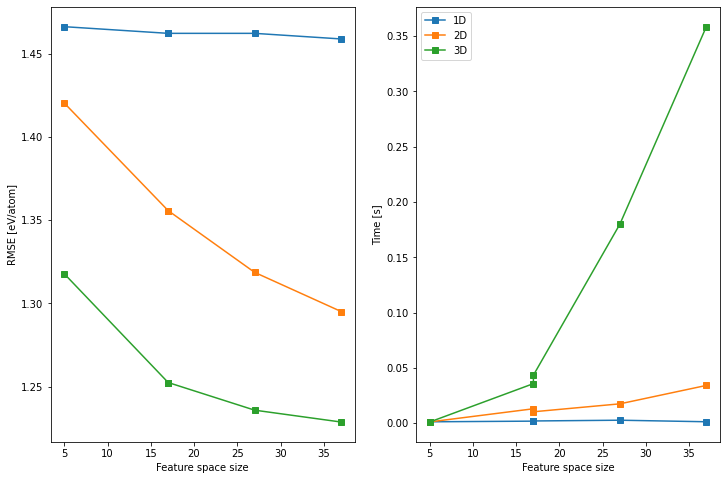

In [13]:
#plot
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(12,8))
ax1.set_xlabel('Feature space size')
ax2.set_xlabel('Feature space size')
ax1.set_ylabel('RMSE [eV/atom]')
ax2.set_ylabel('Time [s]')
#ax2.set_yscale('log')

for dim in range(1,4):
    ax1.plot(X, Errors[dim-1], 's-', label='%sD' %dim)
    ax2.plot(X, Time[dim-1], 's-', label='%sD' %dim)
ax2.legend(loc='best')
plt.show()

#ignore the errors for now, this is l0. 

#but it has lower RMSE to have lower feature set and more operation including exp and / 


Assume now that we would like to include thousands or millions of (more) complex features to obtain more accurate models...

# Approximations to the $\ell_0$ method
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li >Perform a LASSO minimization and the SISSO method.</li>
<li >Compare the solutions with the ones from the $\ell_0$ method.</li>
</div>

### The LASSO


One state-of-the art approximation to the $\ell_0$ method is the LASSO: 

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_1\}$.

Before performing the LASSO regression we standardize the data to have mean 0 and variance 1, since otherwise the $\ell_2$-norm of a column would affect bias its contribution to the model. <br>
Note that we can use the LASSO also only for feature selection. We use then a least-square model with the selected features afterwards instead of the LASSO model directly.

In [14]:
D.shape[0]

275

In [15]:
def lasso_fit(lam, P, D, feature_list):
    #LASSO
    D_standardized = ss.zscore(D)
    lasso =  Lasso(alpha=lam)
    # P[P>1e308] = 0
    # D_standardized[D_standardized>1e308] = 0

    # if np.any(np.isnan(P)):
    #     print("P error")
        
    # if np.any(np.isnan(D)):
    #     print("D error") 

    D_standardized[np.isnan(D_standardized)] = 0  
    
    lasso.fit(D_standardized, P)
    coef =  lasso.coef_
    
    # get strings of selected features
    selected_indices = coef.nonzero()[0]
    selected_features = [feature_list[i] for i in selected_indices]
    
    # get RMSE of LASSO model
    P_predict = lasso.predict(D_standardized)
    RMSE_LASSO = np.linalg.norm(P-P_predict) / np.sqrt(D.shape[0])

    #get RMSE for least-square fit
    D_new = D[:, selected_indices]
    D_new = np.column_stack((D_new, np.ones(D.shape[0])))
    RMSE_LS = np.sqrt(np.linalg.lstsq(D_new, P, rcond=-1)[1][0]/D.shape[0])
        
    return RMSE_LASSO, RMSE_LS, coef, selected_features

$\lambda$ regulates the sparsity of the coefficient vector of the model. Get the data and try different $\lambda$ by adjusting the varibale lam. How good does LASSO (directly or with a least-square fit afterwards) approximate the L0-method (when the same feature space is used for both)?

In [16]:
#import Data
# selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
# selected_feature_list = ordered_selected_features[:7]

ordered_selected_features = ["EN(T)","Length(x) [A]", "IP(X) [eV]","r-(M) [pm]","r-(T) [pm]"]
selected_feature_list = ordered_selected_features[:5]
allowed_operations = ['+','-','|-|','^2','^3','/'] 
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
features_list = df_D.columns.tolist()

df_features.columns Index(['EN(T)', 'Length(x) [A]', 'IP(X) [eV]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
Selected operations:
 ['+', '-', '|-|', '^2', '^3', '/']
DF_A3 Index(['EN(T)', 'Length(x) [A]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
Number of total features generated: 503


lambda: 0.500	 dimension of descriptor: 2	 RMSE_LASSO: 1.455	 RMSE_LS: 1.258
                          features  abs(nonzero_coefs_LASSO)
0            EN(T)/Length(x) [A]^3                  0.037474
1  |r-(M) [pm]-r-(T) [pm]|/EN(T)^3                  0.155534


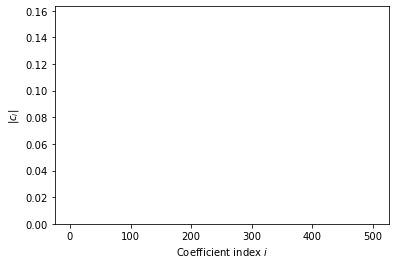

In [17]:
# change lam between 0.02 and 0.34, e.g. 0.34, 0.30, 0.20, 0.13, 0.10, 0.02
lam = 0.5

RMSE_LASSO, RMSE_LS, coef, selected_features = lasso_fit(lam, P, D, features_list)
plt.bar(range(len(coef)), np.abs(coef))
plt.xlabel("Coefficient index $i$")
plt.ylabel("$|c_i|$")

print("lambda: %.3f\t dimension of descriptor: %s\t RMSE_LASSO: %.3f\t RMSE_LS: %.3f" 
      %(lam, len(selected_features), RMSE_LASSO, RMSE_LS))
print(pd.DataFrame({'features':np.array(selected_features), 'abs(nonzero_coefs_LASSO)': np.abs(coef[coef.nonzero()])}))
plt.show()    

# RMSE_LS: 0.585

In [18]:
RMSE_LS

1.2583758792680062

### The SISSO method

In [64]:
#import Data
# selected_feature_list = ['r_s', 'r_p', 'r_d', 'EA', 'IP']
# selected_feature_list = ordered_selected_features[:7] 


df_2 = pd.read_csv("C2DB_Sample_Data_copy_2(dropped).csv") #need to check its location later)
df_2.dropna(inplace=True)
df_2.columns

ordered_selected_features = ["EN(T)","Length(x) [A]", "IP(X) [eV]","r-(M) [pm]","r-(T) [pm]"]
df_2[ordered_selected_features]

selected_feature_list = df_2.columns[5:]
allowed_operations = ['+','-','|-|','^3','^2'] #exp,division seems to be the problem. because zero value cannot. 
P, df_D = get_data(selected_feature_list, allowed_operations)
D = df_D.values
# D=a[a != 0] #would this disrupt the result actually? 

features_list = df_D.columns.tolist()

#the total featured generated is a lot if adding a lot of operators... 15378 

df_features.columns Index(['HoF (eV/atom)', 'E-CH (eV/atom)', 'Length(x) [A]', 'r-(M) [pm]',
       'r-(X) [pm]', 'r-(T) [pm]', 'IP(M) [eV]', 'IP(X) [eV]', 'IP(T) [eV]',
       'EN(M)', 'EN(X)', 'EN(T)', 'EA(M) [eV]', 'EA(X) [eV]', 'EA(T) [eV]'],
      dtype='object')
Selected operations:
 ['+', '-', '|-|', '^3', '^2']
DF_A3 Index(['HoF (eV/atom)', 'E-CH (eV/atom)', 'Length(x) [A]', 'r-(M) [pm]',
       'r-(X) [pm]', 'r-(T) [pm]', 'EN(M)', 'EN(X)', 'EN(T)'],
      dtype='object')
Number of total features generated: 258


 How does the SISSO method compare to the LASSO and to the $\ell_0$-regularization in terms of accuracy (again when using the same feature space)? How fast is SISSO compared to the $\ell_0$-regularization? How does n_features_per_sis_iter (the number of features collected per sis iteration) affect the performance? Note, that for n_features_per_sis_iter=1 SISSO becomes the so-called orthogonal matching pursuit, another well-known compressed sensing method.

In [6]:
sisso = SissoRegressor(n_nonzero_coefs=10, n_features_per_sis_iter=2)

sisso.fit(D, P) #error 
sisso.print_models(features_list)

#why the error comes out when the n_features_per_sis_iter>=9) 
#  'NoneType' object is not iterable: 
# Basically this error means that the object we are trying to iterate over is NoneType i.e. is None . In simpler words, we are trying to run a for loop on a None object.

#is iteration more powerful in bringing the RMSE down? 

#for SISSO, i cannot use / and exp somehow. 

#RMSE increase after more than 1 iteration. 

#how do we check the overfitting problem? 

NameError: name 'D' is not defined

# Predicting new materials (extrapolation)
<div style="list-style:disc; margin: 2px;padding: 10px;border: 0px;border:8px double   green; font-size:16px;padding-left: 32px;padding-right: 22px; width:89%">
<li>Perform a leave-one-out cross-validation (LOOCV) using SISSO.</li> (similar to k cross validation as suggested by prof tej?)
<li>Analyze the prediction accuracy and how often the same descriptor is selected.</li>
</div>

We test the prediction performance for other materials via LOOCV.  In a LOOCV for each material the following procedure is performed: the selected material is excluded, the model is built on the remaining materials and the model accurcy is tested on the excluded material. This means that we need to run SISSO function 82 times. <br>
Get the data in the next cell and run the LOOCV  one cell after. Note that running the LOOCV  could take up to ten minutes. Use the remaining two cells of this chapter to analyse the results.<br>
How is the prediction error compared to the fitting error? How often is the same descriptor selected? Are there materials that yield an outlying high/low error? 

In [30]:
df = pd.read_csv("C2DB_Sample_Data_copy_2(dropped).csv") #need to check its location later)
df.dropna(inplace=True)
df.columns

ordered_selected_features = ["EN(T)","Length(x) [A]", "IP(X) [eV]","r-(M) [pm]","r-(T) [pm]"]
df[ordered_selected_features]

selected_feature_list = df.columns[5:] #this is from the entire dataset. 
allowed_operations = ['+','-','|-|','^3','^2'] #exp,division seems to be the problem. because zero value cannot. 

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
chemical_formulas = df_D.index.tolist()
D = df_D.values

df_features.columns Index(['HoF (eV/atom)', 'E-CH (eV/atom)', 'Length(x) [A]', 'r-(M) [pm]',
       'r-(X) [pm]', 'r-(T) [pm]', 'IP(M) [eV]', 'IP(X) [eV]', 'IP(T) [eV]',
       'EN(M)', 'EN(X)', 'EN(T)', 'EA(M) [eV]', 'EA(X) [eV]', 'EA(T) [eV]'],
      dtype='object')
Selected operations:
 ['+', '-', '|-|', '^3', '^2']
DF_A3 Index(['HoF (eV/atom)', 'E-CH (eV/atom)', 'Length(x) [A]', 'r-(M) [pm]',
       'r-(X) [pm]', 'r-(T) [pm]', 'EN(M)', 'EN(X)', 'EN(T)'],
      dtype='object')
Number of total features generated: 258


In [33]:
# Leave-one-out cross-validation
n_compounds = len(P)
dimensions = range(1, 9)
features_count = [[] for i in range(8)]
P_predict = np.empty([len(dimensions), n_compounds])

sisso = SissoRegressor(n_nonzero_coefs=8, n_features_per_sis_iter=2)
loo = LeaveOneOut()

for indices_train, index_test in loo.split(P):
    i_cv = index_test[0]
    print('%2s) Leave out %s: Ediff_ref = %.3f eV' 
          % (index_test[0]+1, chemical_formulas[i_cv], P[i_cv]))
        
    sisso.fit(D[indices_train], P[indices_train])
    sisso.print_models(features_list)    
    
    for dim in dimensions:      
        features = [features_list[i] for i in sisso.l0_selected_indices[dim - 1]]
        predicted_value = sisso.predict(D[index_test], dim=dim)[0]
        
        features_count[dim-1].append( tuple(features) )        
        P_predict[dim-1, i_cv] = predicted_value
        
        print('Ediff_predicted(%sD) = %.3f eV' %(dim, predicted_value))
    print('-----') #unit for workfunction is eV. change that later. 

 1) Leave out 0: Ediff_ref = 2.271 eV
          RMSE            Model
1D:	1.388402	+ 1.310 |EN(X)-EN(T)| + 3.193
2D:	1.278357	+ 1.290 |EN(X)-EN(T)| + 0.187 (HoF (eV/atom)+EN(T))^2 + 2.436
3D:	1.052904	+ 1.780 |EN(X)-EN(T)| + 0.152 (EN(M)+EN(T))^2 - 0.812 (EA(X) [eV]+EA(T) [eV]) + 1.421
4D:	0.891212	+ 1.813 |EN(X)-EN(T)| + 0.217 (EN(M)+EN(T))^2 + 1.150 (IP(X) [eV]+EA(T) [eV]) + 2.593 (EA(X) [eV]-EA(T) [eV]) - 15.772
5D:	0.774123	+ 1.562 |EN(X)-EN(T)| + 0.172 (EN(M)+EN(T))^2 - 4242949.257 (EA(X) [eV]+EA(T) [eV]) - 2454126.441 (IP(X) [eV]-EA(T) [eV]) - 1788821.889 (EA(X) [eV]-EA(T) [eV]) + 35246295.214
6D:	0.728640	+ 1.613 |EN(X)-EN(T)| + 0.316 (EN(M)+EN(T))^2 + 1.439 (IP(X) [eV]+EA(T) [eV]) + 3.305 (EA(X) [eV]-EA(T) [eV]) - 0.200 EN(M)^3 - 0.020 |r-(M) [pm]-r-(T) [pm]| - 19.838
7D:	0.655891	+ 1.508 |EN(X)-EN(T)| + 0.348 (EN(M)+EN(T))^2 + 1.425 (IP(X) [eV]+EA(T) [eV]) + 3.279 (EA(X) [eV]-EA(T) [eV]) - 0.279 EN(M)^3 - 0.021 |r-(M) [pm]-r-(T) [pm]| + 1.868 E-CH (eV/atom) - 20.475
8D:	0.6145

In [49]:
P_predict[7, i_cv]

3.166967708617449

In [53]:
#Plot Prediction errors

prediction_errors = np.linalg.norm(P-P_predict, axis=1)/np.sqrt(n_compounds)
xs = [P] *8
ys = P_predict
legend = ['%sD, RMSE = %.3f eV' %(dim, prediction_errors[dim-1]) for dim in dimensions]
data_point_labels = [df.index.tolist()]*8

show_scatter_plot(xs, ys, data_point_labels=data_point_labels, 
                  x_label='WF_DFT', y_label='WF_predicted', legend=legend, unit='eV')

In [59]:
#Plot Prediction errors


In [ ]:
# Print descriptor selection frequency
print("Descriptor selection frequency")
for dim in dimensions:    
    df_frequency = pd.DataFrame( Counter(features_count[dim-1]).most_common(10), columns=['Features', 'Frequency'] )
    print('-----------------\n%sD:\n%s' % (dim, df_frequency))

# create table to display errors and models
feat = np.array(features_count).flatten('F')
Pred = np.array(P_predict).flatten('F')
Pred_errors = np.abs(P-P_predict).flatten('F')
Ref_values = [r for p in P for r in [p,p,p] ]
Mats = [m for mat in chemical_formulas for m in [mat, mat, mat] ]
Dims = ['1D','2D','3D'] * n_compounds

df_loo = pd.DataFrame(list(zip(Ref_values,Pred,Pred_errors,feat)), index = [Mats,Dims],
                  columns=['P_ref[eV]', 'P_pred[eV]', 'abs. error [eV]', 'Selected features'])

#  if you do not want to sort the data frame by the prediction error comment out the next line 
df_loo = df_loo.sort_values('abs. error [eV]', ascending=False)
pd.set_option('display.expand_frame_repr', False)

display(df_loo)

#but it's not that accurate of a prediction model... can be very wonky.

Descriptor selection frequency
-----------------
1D:
           Features  Frequency
0  (|EN(X)-EN(T)|,)        275
-----------------
2D:
                                   Features  Frequency
0  (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T))^2)        259
1  (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T))^3)         10
2          (|EN(X)-EN(T)|, (EN(M)+EN(T))^2)          6
-----------------
3D:
                                            Features  Frequency
0  (|EN(X)-EN(T)|, (EN(M)+EN(T))^2, (EA(X) [eV]+E...        194
1  (|EN(X)-EN(T)|, (EN(M)+EN(T))^3, (EA(X) [eV]+E...         65
2  (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T)), (EA(X) ...         10
3  (|EN(X)-EN(T)|, (EN(M)+EN(T))^2, |IP(M) [eV]-E...          4
4  (|EN(X)-EN(T)|, (EN(M)+EN(T))^2, (IP(M) [eV]-E...          2


P_ref[eV]  P_pred[eV]  abs. error [eV]                                  Selected features
267 3D   7.271891    3.045929         4.225962  (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T)), (EA(X) ...
    2D   7.271891    3.096042         4.175849           (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T))^2)
175 2D   7.231218    3.168931         4.062287           (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T))^2)
    3D   7.231218    3.233565         3.997653  (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T)), (EA(X) ...
267 1D   7.271891    3.684451         3.587440                                   (|EN(X)-EN(T)|,)
...           ...         ...              ...                                                ...
162 3D   5.071202    5.063603         0.007599  (|EN(X)-EN(T)|, (EN(M)+EN(T))^3, (EA(X) [eV]+E...
31  3D   4.287109    4.281052         0.006057  (|EN(X)-EN(T)|, (EN(M)+EN(T))^2, (EA(X) [eV]+E...
121 3D   4.803881    4.800458         0.003423  (|EN(X)-EN(T)|, (EN(M)+EN(T))^2, (EA(X) [eV]+E...
231 1D   4.394605    4.394108         0.000497                                   (|EN(X)-EN(T)|,)
232 2D   4.872037    4.872254         0.000218           (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T))^2)

[825 rows x 4 columns]

In [ ]:
#check if the data overfitted or not 
# improve the graph 

In [ ]:
#  if you do not want to sort the data frame by the prediction error comment out the next line 
df_loo = df_loo.sort_values('abs. error [eV]', ascending=False)
pd.set_option('display.expand_frame_repr', False)

display(df_loo)

df_loo.to_csv(r'/Users/jiwooseo/Desktop/prediction_values.csv')

P_ref[eV]  P_pred[eV]  abs. error [eV]                                  Selected features
267 3D   7.271891    3.045929         4.225962  (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T)), (EA(X) ...
    2D   7.271891    3.096042         4.175849           (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T))^2)
175 2D   7.231218    3.168931         4.062287           (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T))^2)
    3D   7.231218    3.233565         3.997653  (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T)), (EA(X) ...
267 1D   7.271891    3.684451         3.587440                                   (|EN(X)-EN(T)|,)
...           ...         ...              ...                                                ...
162 3D   5.071202    5.063603         0.007599  (|EN(X)-EN(T)|, (EN(M)+EN(T))^3, (EA(X) [eV]+E...
31  3D   4.287109    4.281052         0.006057  (|EN(X)-EN(T)|, (EN(M)+EN(T))^2, (EA(X) [eV]+E...
121 3D   4.803881    4.800458         0.003423  (|EN(X)-EN(T)|, (EN(M)+EN(T))^2, (EA(X) [eV]+E...
231 1D   4.394605    4.394108         0.000497                                   (|EN(X)-EN(T)|,)
232 2D   4.872037    4.872254         0.000218           (|EN(X)-EN(T)|, (HoF (eV/atom)+EN(T))^2)

[825 rows x 4 columns]

## Kernel ridge regression (read more into this!)
It is instructive to compare the performance of the just identified model with a model trained with the popular kernel ridge regression (KRR) approach, by using the same list of atomic features as input. 
KRR solves a $\ell_2$ regularized linear regression problem, with (typically) a nonlinear kernel.
This can be descirbed in the following manner. The $\ell_2$ regularized linear regression problem is:

$\text{argmin}_{\mathbf{c} \in \mathbb{R}^{m}} \{\|\mathbf{P} - \mathbf{D}\mathbf{c}\|^2_2 +\lambda \|\mathbf{c}\|_2\}$.

Its solution is:

$\mathbf{c} = \left( \mathbf{D}^\top \mathbf{D} + \lambda \mathbf{I} \right)^{-1} \mathbf{D}^\top \mathbf{P}$

Acoording to Hilbert space representaiton theorem, we can write the solution vector $\mathbf{c}$ as a linear expansion over the data points represented acoording to the chosen descriptor. In other words, $\mathbf{c}$ can be represented as a linear expansion over the rows $\mathbf{d}_j$ of the matrix $\mathbf{D}$.

$\mathbf{c} = \sum_j \alpha_j \mathbf{d}_j $

This rewriting leads to the equivalent problem:

$\text{argmin}_{\boldsymbol{\alpha} \in \mathbb{R}^{N}} \{\|\mathbf{P} - \mathbf{K}\boldsymbol{\alpha}\|^2_2 +\lambda \boldsymbol{\alpha}^\top \mathbf{K} \boldsymbol{\alpha} \} \quad (1)$,

where the kernel $\mathbf{K}$ is: $K_{ij} = < \mathbf{d}_i, \mathbf{d}_j > $.

The rewritten problem has solution $\boldsymbol{\alpha} = \left( \mathbf{K} + \lambda \mathbf{I} \right)^{-1} \mathbf{P} \quad (2)$

This rewriting did not add anything to the regularized linear regression approoach. If, however, we now expand the vector $\mathbf{c}$ as an expansion of nonlinear functions $\Phi()$ of the vectors $\mathbf{d}_j: 

$\mathbf{c} = \sum_j \alpha_j \Phi(\mathbf{d}_j) $

and the kernel as: $K_{ij} = < \Phi(\mathbf{d}_i), \Phi(\mathbf{d}_j)> $, one can prove that the same problem (1) with the same solution (2) holds. Normally, people do not specify the function $\Phi()$, but rahter the kernel.
Actually, $\Phi()$ does not need to be known at all. We refer to the specialized literature on KRR for more details on this method.

Here, we make use of the Gaussian kernel, i.e., the most popular one:

$K(x, y) = \exp(-\gamma ||x-y||^2)$.

The parameters $\lambda$ and $\gamma$ are called <i> hyperparameters </i> and are set via CV. 
Specifically, at each LOOCV step, the hyperparameters ($\ell_2$-regularization parameter $\lambda$ and inverse gaussian width $\gamma$) are optimized via a grid search and a so-called 5-fold cross-validation on the training set. This means splitting the training set in 5 subsets, 1 subset is used for evaluating the performance (RMSE) and the other 4 for training. The procedure is repeated 5 times by changing the test subset and the overall perfrmance is the RMSE over all repetitions. 

What can one observe by comparing the SISSO and KRR results?

In [65]:
selected_feature_list = ["EN(T)","Length(x) [A]", "IP(X) [eV]","r-(M) [pm]","r-(T) [pm]"]
#selected_feature_list = df.columns[5:] #this is from the entire dataset. 
allowed_operations = ['+','-'] 

P, df_D = get_data(selected_feature_list, allowed_operations)
features_list = df_D.columns.tolist()
D = df_D.values

df_features.columns Index(['EN(T)', 'Length(x) [A]', 'IP(X) [eV]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
Selected operations:
 ['+', '-']
DF_A3 Index(['EN(T)', 'Length(x) [A]', 'r-(M) [pm]', 'r-(T) [pm]'], dtype='object')
Number of total features generated: 17


In [66]:
kr = GridSearchCV(KernelRidge(kernel='rbf'), cv=5,
                  param_grid={"alpha": np.logspace(-3, 0, 5),
                              "gamma": np.logspace(-2, 1, 5)})
P_predict_kr = []
loo = LeaveOneOut()
for indices_train, index_test in loo.split(P):
    kr.fit(D[indices_train], P[indices_train])
    print("%2i Ediff_ref: %.3f, Ediff_pred: %.3f, hyperparameters: {'lambda': %.3f, 'gamma':%.3f}" 
          % (index_test[0], P[index_test], kr.predict(D[index_test]), 
          kr.best_params_['alpha'], kr.best_params_['gamma']))
    P_predict_kr.append(kr.predict(D[index_test])[0])

# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').


 0 Ediff_ref: 2.271, Ediff_pred: 2.151, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
 1 Ediff_ref: 1.588, Ediff_pred: 0.618, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
 2 Ediff_ref: 2.210, Ediff_pred: 2.453, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
 3 Ediff_ref: 2.463, Ediff_pred: 6.255, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
 4 Ediff_ref: 2.330, Ediff_pred: 5.362, hyperparameters: {'lambda': 0.006, 'gamma':0.010}
 5 Ediff_ref: 2.429, Ediff_pred: 2.753, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
 6 Ediff_ref: 6.244, Ediff_pred: 6.330, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
 7 Ediff_ref: 4.425, Ediff_pred: 4.428, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
 8 Ediff_ref: 4.468, Ediff_pred: 1.613, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
 9 Ediff_ref: 6.714, Ediff_pred: 7.800, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
10 Ediff_ref: 5.011, Ediff_pred: 5.402, hyperparameters: {'lambda': 0.001, 'gamma':0.010}
11 Ediff_r

In [63]:
prediction_rmse_kr = np.linalg.norm(np.array(P_predict_kr) - P)/np.sqrt(P.size)

xs = [P, P]
ys = [P_predict[-1], P_predict_kr,]
legend = ['SISSO 8D, RMSE = %.3f eV' % prediction_errors[dim-1], 
          'KR, RMSE = %.3f eV' % prediction_rmse_kr]
data_point_labels = [df.index.tolist()]*2

show_scatter_plot(xs, ys, data_point_labels=data_point_labels, 
                  x_label='WF_DFT', y_label='WF_predicted', legend=legend, unit='eV')

#without operator: RMSE=1.4, with '+'= 1.279, with '+ and '-' = 

In [70]:
prediction_rmse_kr = np.linalg.norm(np.array(P_predict_kr) - P)/np.sqrt(P.size)

xs = [P, P]
ys = [P_predict_kr,P_predict[-1]]
legend = ['KR, RMSE = %.3f eV' % prediction_rmse_kr,
          'SISSO 8D, RMSE = 0.6152 eV' ]
data_point_labels = [df.index.tolist()]*2

show_scatter_plot(xs, ys, data_point_labels=data_point_labels, 
                  x_label='WF_DFT', y_label='WF_predicted', legend=legend, unit='eV')

#without operator: RMSE=1.4, with '+'= 1.279, with '+ and '-' = 